In [237]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import preprocessing

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import seaborn as sns

[nltk_data] Downloading package stopwords to /home/himani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [238]:
#read the data set
data = pd.read_csv("./Data/multilabel_emotion_dataset.csv",sep="\t",encoding="utf-8")

data_phrase=pd.DataFrame()
data['Phrase']=data['Tweet']

# print type(data_phrase)
df_emo=data
df_emo=df_emo.drop(["ID","Tweet","Phrase"],axis=1)

categories=list(df_emo.columns.values)

# print data_phrase
# print data['Emotion'].unique()
# print data.shape

### Number of texts in each Emotion

In [239]:
counts = []
# categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_emo[i].sum()))
# print counts
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,anger,2544
1,anticipation,978
2,disgust,2602
3,fear,1242
4,joy,2477
5,love,701
6,optimism,1984
7,pessimism,795
8,sadness,2009
9,surprise,361


Text(0.5,0,'# of categories')

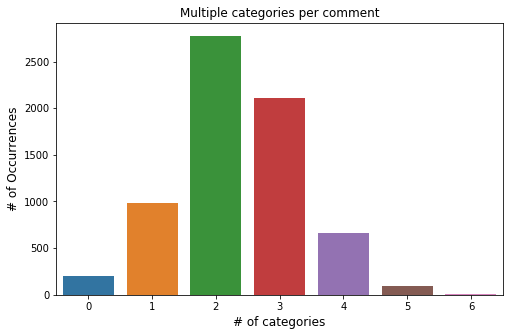

In [240]:
rowsums = data.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

# plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [241]:
print('Percentage of comments that are not labelled:')
print(len(data[(data['anger']==0) & (data['anticipation']==0) & (data['disgust']==0) & (data['fear']== 0) & (data['joy']==0) & (data['love']==0)&(data['optimism']==0)&(data['pessimism']==0)&(data['sadness']==0)&(data['surprise']==0)&(data['trust']==0)]) / len(data))

Percentage of comments that are not labelled:
0


In [242]:
print('Number of missing comments in comment text:')
data['Tweet'].isnull().sum()

Number of missing comments in comment text:


0

## Preprocess the data set via cleaning, tokenisation and lemmatization

In [243]:
# print data
import re

def clean_dataset(data_cf):
    translator = string.maketrans('', '')
    l=[]
    for index,row in data_cf.iterrows():
        row['Phrase'] = row['Phrase'].replace('[','')
        row['Phrase'] = row['Phrase'].replace(']','')
        row['Phrase'] = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', row['Phrase'])
        row['Phrase'] = re.sub('@[^\s]+','USER', row['Phrase'])
#         row['Phrase'] = row['Phrase'].lower().replace("ё", "е")
        row['Phrase'] = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', row['Phrase'])
        row['Phrase'] = re.sub(' +',' ', row['Phrase'])
        row['Phrase'] = row['Phrase'].strip()
        row['Phrase']=re.sub(r'([^\s\w]|_)+', '', row['Phrase'])
        l.append(row['Phrase'])
#         print row['Phrase']
        
#         row['Phrase'] = row['Phrase'].translate(translator,string.punctuation)
    data_cf['Phrase']=l
    return data_cf
data_clean = clean_dataset(data)
print data_clean.head()

              ID                                              Tweet  anger  \
0  2017-En-21441  [Worrying is a down payment on a problem you m...      0   
1  2017-En-31535  Whatever you decide to do make sure it makes y...      0   
2  2017-En-21068  @Max_Kellerman  it also helps that the majorit...      1   
3  2017-En-31436                                  George S. Patton       0   
4  2017-En-22195  My roommate: it's okay that we can't spell bec...      1   

   anticipation  disgust  fear  joy  love  optimism  pessimism  sadness  \
0             1        0     0    0     0         1          0        0   
1             0        0     0    1     1         1          0        0   
2             0        1     0    1     0         1          0        0   
3             0        0     0    1     0         1          0        0   
4             0        1     0    0     0         0          0        0   

   surprise  trust                                             Phrase  
0       

In [244]:
def tokenise(data):
    ## Convert words to lower case and split them    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    l=[]
    for index,row in data.iterrows():
        text = str(row['Phrase']).lower().split(' ')
        text = [w.strip() for w in text if not w in stops and len(w) >= 2]
        text = " ".join(text)
        row['Phrase'] = text
        l.append(row['Phrase'])
    # split the dataset into tokens
    data['Phrase']=l
    return data
data_token = tokenise(data_clean)
data_token.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,Phrase
0,2017-En-21441,[Worrying is a down payment on a problem you m...,0,1,0,0,0,0,1,0,0,0,1,worrying payment problem may never joyce meyer...
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0,whatever decide make sure makes happy
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0,user also helps majority nfl coaching inept bi...
3,2017-En-31436,George S. Patton,0,0,0,0,1,0,1,0,0,0,0,george patton
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0,roommate okay spell autocorrect terrible first...


In [245]:
def lemmatization(dataset):
    stemmer = SnowballStemmer('english')
    l=[]
    for index,row in dataset.iterrows():
        text = str(row['Phrase']).split()
        stemmed_words = [stemmer.stem(word) for word in text]
#         list_of_words.append(stemmed_words)
        text = " ".join(stemmed_words)
        row['Phrase'] = text
        l.append(row['Phrase'])
        
    data['Phrase'] = l
    return dataset
data_stemmed = lemmatization(data_token)
data_stemmed.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,Phrase
0,2017-En-21441,[Worrying is a down payment on a problem you m...,0,1,0,0,0,0,1,0,0,0,1,worri payment problem may never joyc meyer mot...
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0,whatev decid make sure make happi
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0,user also help major nfl coach inept bill brie...
3,2017-En-31436,George S. Patton,0,0,0,0,1,0,1,0,0,0,0,georg patton
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0,roommat okay spell autocorrect terribl firstwo...


In [246]:
def bag_of_words(data):
    count_vect=CountVectorizer()
    count_vect.fit(data) #creates vocab of words
#     print (count_vect.vocabulary_)
    data_phrase=count_vect.transform(data)
#     print(data_phrase.shape)
#     print(type(data_phrase))
#     print(data_phrase.toarray())
    return data_phrase,count_vect
data_phrase,count_vect=bag_of_words(data_stemmed['Phrase'])
data_phrase.shape


(6839, 9612)

In [247]:
def tf_idf(data_phrase):
    tfidf_transformer = TfidfTransformer()
    phrase_tfidf = tfidf_transformer.fit_transform(data_phrase)
    return phrase_tfidf.toarray(),tfidf_transformer
phrase_tfidf,tfidf_transformer=tf_idf(data_phrase)
phrase_tfidf.shape

(6839, 9612)

In [248]:
# Import LabelEncoder
# #creating labelEncoder
# le = preprocessing.LabelEncoder()
# # Converting string labels into numbers.
# emotion_data=data['Emotion'].values
# emo_enc=le.fit_transform(emotion_data)
# print emo_enc



In [249]:
train_phrase, validate_phrase = np.split(phrase_tfidf,[int(.8*len(phrase_tfidf))])
# train_label,validate_label=np.split(emotion_data,[int(.8*len(emotion_data))])
train_label,validate_label=np.split(df_emo,[int(.8*len(df_emo))])
print "data",train_phrase.shape,validate_phrase.shape
print "label",train_label.shape,validate_label.shape
# print train_phrase

data (5471, 9612) (1368, 9612)
label (5471, 11) (1368, 11)


In [250]:
models_all=[]
for category in categories:
    print('... Processing {}'.format(category))
    model=OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))
    model.fit(train_phrase,train_label[category])
    models_all.append(model)
    label_predicted=model.predict(validate_phrase)
    print('Test accuracy is {}'.format(accuracy_score(validate_label[category], label_predicted)))

... Processing anger
Test accuracy is 0.758771929825
... Processing anticipation
Test accuracy is 0.847222222222
... Processing disgust
Test accuracy is 0.722222222222
... Processing fear
Test accuracy is 0.820175438596
... Processing joy
Test accuracy is 0.77485380117
... Processing love
Test accuracy is 0.902046783626
... Processing optimism
Test accuracy is 0.725877192982
... Processing pessimism
Test accuracy is 0.883040935673
... Processing sadness
Test accuracy is 0.748538011696
... Processing surprise
Test accuracy is 0.949561403509
... Processing trust
Test accuracy is 0.953947368421


In [251]:
def data_preprocess(text):
#     cleaning
    translator = string.maketrans('', '')
    text = text.replace('[','')
    text = text.replace(']','')
    text = text.strip()
    text = text.translate(translator,string.punctuation)
#     stop word removal
    stops = set(stopwords.words("english"))
    text = text.lower().split(' ')
    text = [w.strip() for w in text if not w in stops and len(w) >= 2]
    text = " ".join(text)
#     lemmatization
    stemmer = SnowballStemmer('english')
    text = text.split()
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    return text

In [266]:
test_sentence=raw_input("Enter text:")
# test_sentence=""
test_sen=[]
test_sen.append(data_preprocess(test_sentence))
print data_preprocess(test_sentence)
bow=count_vect.transform(test_sen)
tf_test=tfidf_transformer.transform(bow).toarray()
for i in range(0,len(models_all)):
    print('... Processing {}'.format(categories[i]))
    predicted_test= models_all[i].predict(tf_test)
    print predicted_test
# le.inverse_transform(predicted_test)



... Processing anger
[0]
... Processing anticipation
[0]
... Processing disgust
[0]
... Processing fear
[0]
... Processing joy
[0]
... Processing love
[0]
... Processing optimism
[0]
... Processing pessimism
[0]
... Processing sadness
[0]
... Processing surprise
[0]
... Processing trust
[0]
